In [1]:
import os
import sys
import data_prep as dp

import rbm_torch.utils.utils

In [2]:
dataset_focus = "pig"
dataset_id = "ge2"
datatype_str = f"{dataset_focus}_{dataset_id}"
if dataset_id is not None:
    dataset_dir = f"./{dataset_focus}/{dataset_id}/"
else:
    dataset_dir = f"./{dataset_focus}/"

if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)

In [3]:
import data_prep as dp

pig_df = dp.process_raw_fasta_files("b3_cdr3.fasta", "n1_cdr3.fasta", "np1_cdr3.fasta", "np2_cdr3.fasta", "np3_cdr3.fasta", in_dir="/mnt/D1/phage_display_analysis/pig_tissue/fasta files/", out_dir=dataset_dir, violin_out="pid_cdr3_lengths", input_format="fasta")

Observed Characters: ['T', 'M', 'N', 'Y', 'V', 'I', 'H', 'A', 'R', 'C', 'Q', 'F', 'G', 'L', 'D', 'P', 'S', '*', 'K', 'X', 'E', 'W']


In [5]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [1]:
import data_prep as dp
import rbm_torch.analysis.analysis_methods as am

c1_df = am.fetch_data(["np1_c1", "np2_c1", "np3_c1"], dir="./pig/ge2/", threads=6, molecule="protein")

# pig_df = dp.process_raw_fasta_files("np1_cdr3.fasta", "np2_cdr3.fasta", "np3_cdr3.fasta", in_dir="/mnt/D1/phage_display_analysis/pig_tissue/fasta files/", out_dir=dataset_dir, input_format="fasta")
#
# round_dict = {"np1_cdr3": "np1", "np2_cdr3": "np2", "np3_cdr3": "np3"}
# pig_df.replace({"round": round_dict}, inplace=True)

pig_ct = dp.copynum_topology_faster(c1_df, ["np1_c1", "np2_c1", "np3_c1"], threads_per_task=3)
pig_ct.to_csv("./pig/ge2/pig_c1_ct.csv", index=False)

Process Time 0.2646138668060303
Process Time 0.10947895050048828
Process Time 0.2322840690612793
Process Time 227.3993489742279


In [5]:
import pandas as pd
import numpy as np
# reads per hundred thousand
pig_pd = pd.read_csv("./pig/pig_c1_ct.csv")
for r in ["np1_c1", "np2_c1", "np3_c1"]:
    print(f"millions of reads {r}", pig_pd[r].sum()/100000)
    pig_pd[r] = pig_pd[r].div(pig_pd[r].sum()/100000)
pig_pd["mean"] = pig_pd.apply(lambda row : np.nanmean(np.asarray([row[x] for x in ["np1_c1", "np2_c1", "np3_c1"]])), axis=1)
pig_pd["max"] = pig_pd.apply(lambda row : np.nanmax(np.asarray([row[x] for x in ["np1_c1", "np2_c1", "np3_c1"]])), axis=1)

millions of reads np1_c1 1.75492
millions of reads np2_c1 0.89682
millions of reads np3_c1 3.86058


In [8]:
pig_pd.head()

,sequence,np1_c1,np2_c1,np3_c1,mean,max,32_fold,31_fold
0,AGLAGQKYNELNS---------,9.687051,1.115051,0.259028,3.687044,9.687051,0.232302,0.026740
1,ATPGSTPHT-MRF---------,0.569827,2.230102,3.885427,2.228452,3.885427,1.742264,6.818613
2,ASMMVAYVKT-WTTGATKEVSF,2.849133,2.230102,NaN,2.539617,2.849133,NaN,NaN
3,ARDDYLGTDQFEY---------,0.569827,NaN,1.036114,0.802970,1.036114,NaN,1.818297
4,ARARWEQPAELNY---------,2.279306,NaN,0.777085,1.528196,2.279306,NaN,0.340931


In [7]:
pig_pd["32_fold"] = pig_pd.apply(lambda row: row["np3_c1"]/row["np2_c1"], axis=1)
pig_pd["31_fold"] = pig_pd.apply(lambda row: row["np3_c1"]/row["np1_c1"], axis=1)

In [16]:
from copy import copy
e1 = pig_pd[(pig_pd["32_fold"]>1.) | (pig_pd["31_fold"] > 1.)]
e2 = e1[((e1["32_fold"] > 1) | (np.isnan(e1["32_fold"]))) & ((e1["31_fold"] > 1) | (np.isnan(e1["31_fold"])))]
enriched = copy(e2)

enriched["fold"] = enriched.apply(lambda row: np.nanmax(np.asarray([row["31_fold"], row["32_fold"]])), axis=1)

In [17]:
get_len(enriched)

13897


In [23]:
from rbm_torch.utils.seq_utils import prune_similar_sequences
enriched.sort_values("fold", ascending=False, inplace=True)
enriched_trimmed = prune_similar_sequences(enriched, hamming_threshold=4, molecule="protein")

Kept 13499 of 13897


In [24]:
from rbm_torch.utils import data_prep as dp
dp.dataframe_to_fasta(enriched_trimmed, "./pig/enriched_c1.fasta", count_key="fold")

In [27]:
from rbm_torch.utils.utils import fasta_read
seqs, folds, chars, q = fasta_read("./pig/enriched_c1.fasta", "protein", threads=5)

Process Time 0.016733407974243164


In [33]:
std_folds = dp.standardize_affinities(folds, out_plots="./pig/enrich", scale="log", dividers=[25], target_scaling=[3.5])

In [34]:
dp.make_weight_file("en_c1_fold", std_folds, dir="./pig/")

In [12]:
def get_len(dataframe):
    print(dataframe.index.__len__())

get_len(e2)

15105


In [12]:
pig_pd.sort_values("mean", ascending=True, inplace=True)
pig_pd.head(50)
print(pig_pd.index.__len__())

76398


In [25]:
ones = pig_pd[pig_pd["mean"] >= 2.0]
max = pig_pd[pig_pd["max"] >= 5.0]
ones_max = ones[ones["max"] >= 6]
print(ones.index.__len__(), ones_max.index.__len__(), max.index.__len__())

47160 18865 24459


In [26]:
# merged np1_c1, np2_c1, and np3_c1 sequences, with max count number
dp.dataframe_to_fasta(max, "./pig/ge2/m1.fasta", count_key="max")

In [24]:
import data_prep as dp
dp.quick_hist(pig_pd["max"].tolist(), "./pig/ge2/pig_c1_max.png")

In [20]:
from rbm_torch.utils import utils
import data_prep as dp

fasta_file = "h1_c1.fasta"
dataset_dir = "./pig/ge2/"

seqs, affs, chars, q = utils.fasta_read(dataset_dir+fasta_file, "protein")
naffs = dp.standardize_affinities(affs, out_plots=dataset_dir+f"{fasta_file.split('.')[0]}_m", scale="log", dividers=[15, 50, 80], target_scaling=[1., 1.2, 1.2], divider_type="percentile")
naffs = dp.standardize_affinities(affs, out_plots=dataset_dir+f"{fasta_file.split('.')[0]}_m2", scale="log", dividers=[50], target_scaling=[2.], divider_type="percentile")
dp.make_weight_file(f"{dataset_dir}{fasta_file.split('.')[0]}_m", naffs, "m")
dp.make_weight_file(f"{dataset_dir}{fasta_file.split('.')[0]}_m2", naffs, "m2")

Process Time 0.10312104225158691


In [22]:
import subprocess as sp
import os
# no weights
os.chdir("../rbm_torch")
# sp.check_call(f"python submit.py -d pig_ge2 -r m1_c1 -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2", shell=True)
# sp.call(f"python submit.py -d pig_ge2 -r m1_c1 -p wzhengpu1 -q wildfire -m rbm -e 200 -g 1", shell=True)
# weights
sp.call(f"python submit.py -d pig_ge2 -r h1_c1 -p sulcgpu3 -q sulcgpu1 -m crbm -e 4000 -g 2", shell=True)
for wfile in ["h1_c1_m.json", "h1_c1_m2.json"]:
    sp.call(f"python submit.py -d pig_ge2 -r h1_c1 -p sulcgpu3 -q sulcgpu1 -m crbm -e 4000 -g 2 -w {wfile}", shell=True)

In [14]:
pig_pd.sort_values("np3_c1", ascending=False, inplace=True)
pig_pd.head(50)

,sequence,np1_c1,np2_c1,np3_c1,mean,max
75722,ASNSPGKKQFRF----------,26.0,103.0,8085.0,2738.000000,8085.0
12373,AGRRRRTANFRY----------,78.0,127.0,6401.0,2202.000000,6401.0
37135,ATHIAMKGTWKNWHPQSLHY--,59.0,83.0,2210.0,784.000000,2210.0
36274,AAGIKGHHPTVRF---------,4.0,46.0,2207.0,752.333333,2207.0
40455,ARRLRDAPEVDF----------,59.0,38.0,1614.0,570.333333,1614.0
39307,AATKPKGRLGYSTMSY------,26.0,68.0,1572.0,555.333333,1572.0
44315,ASGSGMRKEKLTY---------,42.0,28.0,1443.0,504.333333,1443.0
71442,ARNIEWSSYLSY----------,29.0,46.0,1285.0,453.333333,1285.0
40070,AAGWGRRGSSYLKF--------,1.0,25.0,908.0,311.333333,908.0
42962,ATWGAIKKEAMKY---------,12.0,19.0,852.0,294.333333,852.0


In [5]:
# Renaming for convenience
round_dict = {"b3_cdr3": "b3", "n1_cdr3": "n1", "np1_cdr3": "np1", "np2_cdr3": "np2", "np3_cdr3": "np3"}
pig_df.replace({"round": round_dict}, inplace=True)

In [ ]:
# So now we can define our datatype

# Datatype defines the basics of our data, Each datatype is specified for a group of related fasta files
# Focus - > short string specifier that gives the overall dataset we are using
# Molecule -> What kind of sequence data? currently protein, dna, and rna are supported
# id -> short string specifier ONLY for datasets which have different clustering methods (CLUSTERS ONLY)
# process -> How were the gaps added to each dataset, used to name directory (CLUSTERS ONLY)
# clusters -> How many clusters are in each data file (1 if no clusters)
# cluster_indices -> Define the lengths of data put in each cluster, It is inclusive so [12, 16] includes length 12 and length 16. There must be cluster_indices for each cluster
# gap_position_indices -> Index where gaps should be added to each sequence that is short of the maximum length. (-1 means add gaps to the end of the clusters)


pig_ge2_datatype = {"focus": "pig", "molecule": "protein", "id": "ge2", "process": "gaps_end", "clusters": 2, "gap_position_indices": [-1, -1], "cluster_indices": [[12, 22], [35, 45]]}

In [4]:
chars_replace = {"*": "-", "X": "-"}
dp.prepare_data_files(datatype_str, pig_df, target_dir=dataset_dir, character_conversion=chars_replace, remove_chars=None) # Creates datafiles in target directory

NameError: name 'dp' is not defined

In [4]:
sys.path.append("../")
import rbm_torch.utils as utils

fasta_files = [f"{x}_c1.fasta" for x in ["b3", "n1", "np1", "np2", "np3"]]
fasta_files += [f"{x}_c2.fasta" for x in ["b3", "n1", "np1", "np2", "np3"]]
for fasta_file in fasta_files:
    seqs, affs, chars, q = utils.fasta_read(dataset_dir+fasta_file, "protein")
    naffs = dp.standardize_affinities(affs, out_plots=dataset_dir+f"{fasta_file.split('.')[0]}_sc", scale="linear", dividers=[15, 50, 80], target_scaling=[5., 10., 20.], divider_type="percentile")
    # print(sum([x for x in naffs if x < 0.1]), sum([x for x in naffs if x >= 0.1]))
    dp.make_weight_file(f"{dataset_dir}{fasta_file.split('.')[0]}_sc", naffs, "sc")

Process Time 0.7732417583465576


/home/jonah/PycharmProjects/phage_display_ML/datasets/data_prep.py:253: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 1)


Process Time 1.0405735969543457
Process Time 1.297820806503296
Process Time 0.6126525402069092
Process Time 1.3889286518096924
Process Time 0.5471639633178711
Process Time 0.7353661060333252
Process Time 1.0253167152404785
Process Time 0.38990020751953125
Process Time 0.48378729820251465


In [5]:
import matplotlib.pyplot as plt
plt.close()

In [18]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [14]:
# Now let's make our input files
!python ../rbm_torch/submit.py -h

usage: submit.py [-h] -d DATATYPE -r ROUND -p PARTITION -q QUEUE -m MODEL -e
                 EPOCHS -g GPUS [--wdir [WDIR]] [--precision PRECISION]
                 [-c [C]] [-w [W]] [--walltime [WALLTIME]] [-a [ACCOUNT]]
                 [--email [EMAIL]] [--error [ERROR]]

Generate Slurm Files for pytorch RBM and CRBM

optional arguments:
  -h, --help            show this help message and exit
  --wdir [WDIR]         Manually Set working directory, Usually handled
                        internally.
  --precision PRECISION
                        Set precision of the model, single or double
  -c [C]                Number of CPU cores to use. Default is 6.
  -w [W]                Weight File name to use to weight model training. Must
                        be in same directory as the sequence files.
                        Alternatively can be 'fasta' or None
  --walltime [WALLTIME]
                        Set wall time for training
  -a [ACCOUNT], --account [ACCOUNT]
              

In [2]:
import subprocess as sp
import os
os.chdir("../rbm_torch/")

prefixes = ["b3", "n1", "np1", "np2", "np3"]
cluster_prefixes = [x+"_c1" for x in prefixes]
cluster_prefixes += [x+"_c2" for x in prefixes]
weights = [x + "_sc.json" for x in cluster_prefixes]

for i in range(len(cluster_prefixes)):
    sp.call(f"python submit.py -d pig_ge2 -r {cluster_prefixes[i]} -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 -w {weights[i]}", shell=True)

## Lets Do DBScan

In [1]:
### Some crap I had to write to fix an import problem
import os
os.chdir("../rbm_torch/")
import rbm_torch.analysis.analysis_methods as am
os.chdir("../datasets/")

Process Time 0.02129673957824707


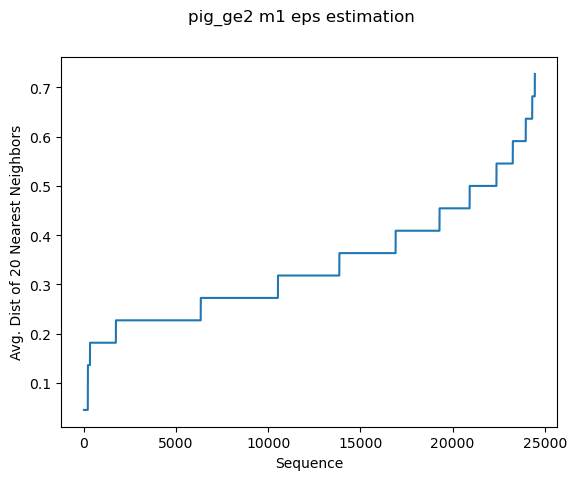

In [3]:
from rbm_torch.utils import utils
import data_prep as dp
import rbm_torch.analysis.clustering_methods as cm

fasta_id = "m1_c1"

seqs, affs, chars, q = utils.fasta_read(f"./pig/ge2/{fasta_id + '.fasta'}", "protein", threads=12)
cat = utils.seq_to_cat(seqs, molecule="protein")

cm.estimate_dbscan_eps(cat, nn=20, title="pig_ge2 m1 eps estimation")

In [11]:
# Estimating off the above graph, we are going to run dbscan at an eps of 0.35 ish
# We are going to choose a minimum samples parameter of 82 as that is double the dimension of our input vectors.
# The above is based off this tutorial: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

m1_labels = cm.cluster_seqs(cat, min_samples=82, eps=0.3)  # 0.2

Clust 0 Length 3312
Clust -1 Length 21147
Estimated number of clusters: 1
Estimated number of noise points: 21147


In [7]:
from sklearn.metrics import pairwise_distances
from rbm_torch.utils import utils
import numpy as np

def hamming_sort(dataframe, hamming_threshold=5, molecule="protein"):

    dataframe.sort_values("copy_num", ascending=False, inplace=True)

    seqs = dataframe.sequence.tolist()
    cns = dataframe.copy_num.tolist()

    cat = utils.seq_to_cat(seqs, molecule=molecule)

    X = cat.numpy().astype(np.int8)

    # X should be a categorical vector of shape (seqs, bases)
    seq_len = len(seqs[0])
    selected_seqs, selected_cns, selected_cat = [], [], []
    total_seqs = len(seqs)
    for i in range(total_seqs):  # len(m1_seqs)
        if i == 0:
            selected_seqs.append(seqs[i])
            selected_cns.append(cns[i])
            selected_cat.append(X[i])
        else:
            dist_matrix = pairwise_distances([X[i]], selected_cat, metric="hamming")*seq_len
            # print(dist_matrix)
            if min(dist_matrix[0]) > hamming_threshold:
                selected_seqs.append(seqs[i])
                selected_cns.append(cns[i])
                selected_cat.append(X[i])

    print(f"Kept {len(selected_seqs)} of {total_seqs}")

    return selected_seqs, selected_cns

In [3]:
import pandas as pd
seqs, affs, chars, q = utils.fasta_read("./pig/ge2/m1_c1.fasta", "protein", threads=12)
m1_pd = pd.DataFrame({"sequence": seqs, "copy_num":affs})


Process Time 0.029875755310058594


In [18]:
mseqs, maffs = hamming_sort(m1_pd, hamming_threshold=2)

Kept 24323 of 24459


In [19]:
dp.write_fasta(mseqs, maffs, "./pig/ge2/h1_c1.fasta")